In [ ]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt


img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [ ]:
# Función para construir el Generador
def build_generator():

    # Definir la forma del ruido de entrada unidimensional de tamaño 100
    noise_shape = (100,)

    # Definir la arquitectura de la Red Generadora
    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Salida del Generador
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=noise_shape)

    # Generar imagen a partir del ruido de entrada
    img = model(noise)

    return Model(noise, img)

# Función para construir el Discriminador
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Función para entrenar el modelo
def train(epochs, batch_size=128, save_interval=50):

    # Cargar el conjunto de datos MNIST
    (X_train, _), (_, _) = mnist.load_data()

    # Convertir y reescalar los datos en un rango de -1 a 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    # Agregar la dimensión de canales a los datos
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        # Entrenar el Discriminador
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entrenar el Generador
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = combined.train_on_batch(noise, valid_y)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

        # Guardar imágenes en intervalos definidos (1000)
        if epoch % save_interval == 0:
            save_imgs(epoch)

# Guarda las imagenes
def save_imgs(epoch):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [ ]:
# Configurar el optimizador
optimizer = legacy_optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Instanciar y compilar el Discriminador
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Instanciar y compilar el Generador
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

# Congelar los pesos del Discriminador durante el entrenamiento del Generador
discriminator.trainable = False

# Conectar el Generador y el Discriminador
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# Definir el directorio para guardar imágenes
save_dir = 'images'

# Crear el directorio si no existe
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Entrenar el modelo
train(epochs=20000, batch_size=32, save_interval=100)

# Guardar el modelo del Generador entrenado
generator.save('generator_model.h5')

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 20ms/step
17512 [D loss: 0.696596, acc.: 59.38%] [G loss: 0.891992]
1/1 [==============================] - 0s 30ms/step
17513 [D loss: 0.604211, acc.: 75.00%] [G loss: 0.918338]
1/1 [==============================] - 0s 30ms/step
17514 [D loss: 0.658762, acc.: 59.38%] [G loss: 0.834601]
1/1 [==============================] - 0s 40ms/step
17515 [D loss: 0.749550, acc.: 40.62%] [G loss: 0.849401]
1/1 [==============================] - 0s 38ms/step
17516 [D loss: 0.716569, acc.: 53.12%] [G loss: 0.773500]
1/1 [==============================] - 0s 43ms/step
17517 [D loss: 0.624498, acc.: 71.88%] [G loss: 0.826290]
1/1 [==============================] - 0s 36ms/step
17518 [D loss: 0.638062, acc.: 75.00%] [G loss: 0.841879]
1/1 [==============================] - 0s 24ms/step
17519 [D loss: 0.634856, acc.: 56.25%] [G loss: 0.842594]
1/1 [==============================] - 0s 22ms/step
17520 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load Trained Model

1/1 [==============================] - 0s 152ms/step


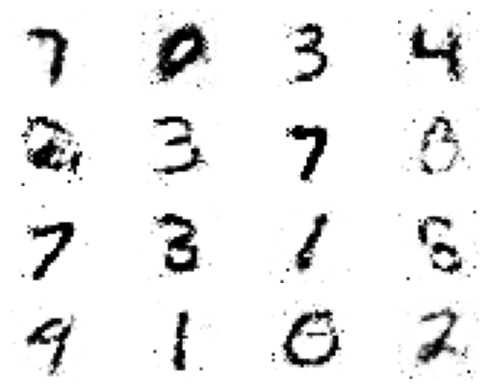

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator_model.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)

